
## План семинара

* знакомство
* организационные вопросы
* по следам лекции MLP


#  Данные

In [1]:
import numpy as np

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


KeyboardInterrupt: 

# Torch MLP

## Определяем модель

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.inner = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.linear_in(x_coordinates)) # [ batch_size, 16 ]
        latents = self.activation(self.linear_mid(latents))      # [ batch_size, 16 ]
        scores = self.linear_out(latents)                        # [ batch_size, 1 ]
        scores = scores[:, 0]                                    # [ batch_size ]

        return scores


model = MLP()
print(model)
print("number of parameters", sum(p.numel() for p in model.parameters()))


MLP(
  (linear_in): Linear(in_features=2, out_features=16, bias=True)
  (linear_mid): Linear(in_features=16, out_features=16, bias=True)
  (linear_out): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
)
number of parameters 337


In [ ]:
print("Parameters shapes:")
print([p.shape for p in model.parameters()])

Parameters shapes:
[torch.Size([16, 2]), torch.Size([16]), torch.Size([16, 16]), torch.Size([16]), torch.Size([1, 16]), torch.Size([1])]


In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.3679, -0.3693],
         [-0.3529, -0.0171],
         [ 0.6142, -0.4936],
         [-0.1211, -0.1992],
         [ 0.1435, -0.0326],
         [ 0.1310, -0.5562],
         [-0.4311, -0.0437],
         [-0.2767,  0.4110],
         [-0.0544, -0.3409],
         [ 0.3283,  0.4284],
         [-0.0205,  0.4776],
         [ 0.1893,  0.1869],
         [-0.3575, -0.0777],
         [ 0.6489, -0.5077],
         [-0.3670,  0.6523],
         [ 0.5564,  0.5807]], requires_grad=True),
 Parameter containing:
 tensor([-0.6390, -0.2026, -0.2316, -0.6851,  0.4538,  0.5457,  0.4635,  0.4155,
         -0.2389,  0.3344,  0.5539, -0.3160, -0.5870, -0.5092,  0.4382, -0.5633],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.2236, -0.0573, -0.0897,  0.1646, -0.0171,  0.2169,  0.0876,  0.1065,
           0.0881, -0.2132,  0.0151,  0.0386,  0.1326,  0.1937, -0.2311,  0.0751],
         [ 0.1101,  0.1823,  0.1508, -0.1993, -0.1349,  0.0378, -0.1785, -0.0055,
      

## Вычисляем лосс

In [ ]:

# loss function
def loss(model, Xbatch, ybatch):

    Xbatch = torch.tensor(Xbatch).float() # [ batch_size, 2 ]
    ybatch = torch.tensor(ybatch).float() # [ batch_size ]

    # forward the model to get scores
    model_prediction = model.forward(Xbatch) # [ batch_size, 1 ]

    # svm "max-margin" loss
    losses = F.relu(1 - ybatch * model_prediction) # [ batch_size ]
    loss = losses.mean()

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())
    total_loss = loss + reg_loss

    # also get accuracy
    accuracy = ((ybatch > 0) == (model_prediction > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss(model, X, y)
print(total_loss, acc)

tensor(1.0108, grad_fn=<AddBackward0>) tensor(0.5400)


In [ ]:
# optimization

def train(model, learning_rate=0.1):

    Xbatch, ybatch = make_moons(n_samples=100, noise=0.1, random_state=1)
    ybatch = y * 2 - 1 # make y be -1 or 1

    for k in range(300):

        model.zero_grad() # обнуляем градиенты с предыдущего шага

        # forward
        total_loss, acc = loss(model, Xbatch, ybatch)

        # backward
        total_loss.backward() # вычисляем новые значения градиентов
        # (model.linear_in.weight.grad)

        # шаг оптимизации
        # update (sgd)
        for p in model.parameters():
            p.data = p.data - learning_rate * p.grad

        if k % 50 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


model = MLP()

train(model, learning_rate=1.0)

step 0 loss 1.0167416334152222, accuracy 50.0%
step 50 loss 0.1296704262495041, accuracy 95.0%
step 100 loss 0.009092330932617188, accuracy 100.0%
step 150 loss 0.005146949086338282, accuracy 100.0%
step 200 loss 0.005055857822299004, accuracy 100.0%
step 250 loss 0.01830948330461979, accuracy 100.0%


(-1.7609251085622153, 1.9890748914377847)

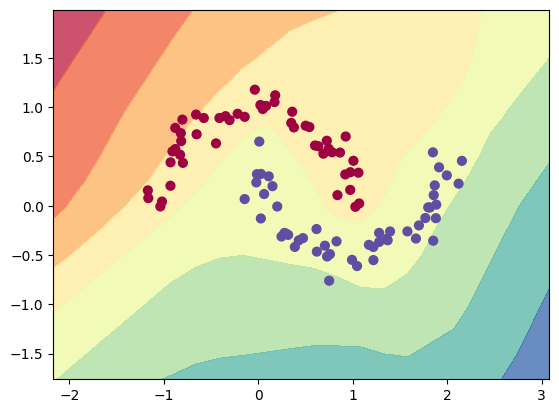

In [ ]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    Xbatch = torch.tensor(Xmesh).float()

    scores = model.forward(Xbatch)

Z = scores.numpy()
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Блиц

### Как луны может разделить логистическая регрессия?

### Чем наша реализация MLP отличается от LinearSVC?

### Зачем мы оборачиваем данные в `torch.tensor` внутри `def loss`?

### Как `learning_rate` влияет на скорость обучения?

### Что будет, если убрать все нелинейности из нашей модели?

### Что сделано неправильно в подсчете accuracy в текущем примере?